In [1]:
import nibabel as nib
import numpy as np
import os
import pandas as pd
import pingouin as pg
import pandas as pd
import seaborn as sns
import scipy.stats

import matplotlib.pyplot as plt

# Set the maximum number of rows to display (set to None for no limit)
pd.set_option('display.max_rows', None)


In [2]:
def load_nifti_volume(nifti_file):
    img = nib.load(nifti_file)
    return img.get_fdata()

def calculate_label_volumes(volume, label_list):
    label_volumes = {}
    for label in label_list:
        label_volumes[label] = np.sum(volume == label)
    return label_volumes

def find_repeats(lst):
    counts = {}
    for item in lst:
        if item in counts:
            counts[item] += 1
        else:
            counts[item] = 1  
    repeats = [item for item, count in counts.items() if count > 1]   
    return repeats

/Users/markolchanyi/opt/anaconda3/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedCheckFailedWarning: Failed to check for latest version of package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [5]:
subjects_names = ["105923",
                "111312",
                "114823",
                "130518",
                "135528",
                "137128",
                "139839",
                "143325",
                "144226",
                "146129",
                "149337",
                "149741",
                "151526",
                "158035",
                "169343",
                "172332",
                "175439",
                "177746",
                "185442",
                "187547",
                "192439",
                "194140",
                "195041",
                "200109",
                "200614",
                "204521",
                "250427",
                "287248",
                "341834",
                "433839",
                "562345",
                "599671",
                "601127",
                "627549",
                "660951",
                "783462",
                "859671",
                "861456",
                "877168",
                "917255"]


repeats = find_repeats(subjects_names)
if repeats:
    print("Repeats in control set!!!:", repeats)


subject_dirs_time1 = ["/Users/markolchanyi/Desktop/BSB_validation/HCP_retest_orig/" + element for element in subjects_names]
subject_dirs_time2 = ["/Users/markolchanyi/Desktop/BSB_validation/HCP_retest/" + element for element in subjects_names]

common_filename = 'bsb_outputs_attention/unet_predictions/unet_results/wmunet.crfseg.mgz'  # Common NIfTI filename in each subject's directory
label_list = [1001,2001,1002,2002,1003,2003,1004,2004,1005,2005,1006,2006,1007,2007,1008,2008]

label_names = ["left MLc", 
               "right MLc",
               "left SCP",
               "right SCP",
               "left LFB",
               "right LFB",
               "left MHB",
               "right MHB",
               "left Bic",
               "right Bic",
               "left MLr",
               "right MLr",
               "left MLF",
               "right MLF",
               "left CTG",
               "right CTG"]


In [6]:
print("number of subjects: ", len(subjects_names))

number of subjects:  40


In [7]:
data = []
for i, subject_dir in enumerate(subject_dirs_time1):
    nifti_file = os.path.join(subject_dir, common_filename)
    if os.path.exists(nifti_file):
        volume = load_nifti_volume(nifti_file)
        label_volumes = calculate_label_volumes(volume, label_list)
        for label, vol in label_volumes.items():
            data.append({'Subject': i+1, 'Time': 1, 'Label': label, 'Volume': vol})
            
for i, subject_dir in enumerate(subject_dirs_time2):
    nifti_file = os.path.join(subject_dir, common_filename)
    if os.path.exists(nifti_file):
        volume = load_nifti_volume(nifti_file)
        label_volumes = calculate_label_volumes(volume, label_list)
        for label, vol in label_volumes.items():
            data.append({'Subject': i+1, 'Time': 2, 'Label': label, 'Volume': vol})

df = pd.DataFrame(data)

# Calculate ICC and 95% CIs
icc_results = {}
CI95_results = {}
for label in label_list:
    df_label = df[df['Label'] == label]
    icc = pg.intraclass_corr(data=df_label, targets='Subject', raters='Time', ratings='Volume',nan_policy='omit')
    icc_result = icc.set_index('Type').loc['ICC3']
    icc_value = icc_result['ICC']
    ci_low = icc_result['CI95%'][0]
    ci_high = icc_result['CI95%'][1]
    icc_results[label] = {'ICC': icc_value, 'CI95%': (ci_low, ci_high)}
    

all_values = list(icc_results.values())  
icc_values = [result['ICC'] for result in all_values]
CI95_values = [result['CI95%'] for result in all_values]


print("ICC Results:")
for count, icc_value in enumerate(icc_values):
    print("   Label:", label_list[count], "ICC value: ", icc_value)
    

print("ICC Results:")
for count, CI_value in enumerate(CI95_values):
    print("   Label:", label_list[count], "ICC value: ", CI_value)

ICC Results:
   Label: 1001 ICC value:  0.926046280823818
   Label: 2001 ICC value:  0.8111252164897435
   Label: 1002 ICC value:  0.9356456749821982
   Label: 2002 ICC value:  0.9188447959103974
   Label: 1003 ICC value:  0.8860155711047597
   Label: 2003 ICC value:  0.9109781208026235
   Label: 1004 ICC value:  0.8210312687913405
   Label: 2004 ICC value:  0.807238798053163
   Label: 1005 ICC value:  0.8305828496875306
   Label: 2005 ICC value:  0.86590770395394
   Label: 1006 ICC value:  0.7455073145374883
   Label: 2006 ICC value:  0.7870066359915838
   Label: 1007 ICC value:  0.8882185413223008
   Label: 2007 ICC value:  0.8798893234176814
   Label: 1008 ICC value:  0.8249670841996958
   Label: 2008 ICC value:  0.8830008258917051
ICC Results:
   Label: 1001 ICC value:  (0.86, 0.96)
   Label: 2001 ICC value:  (0.67, 0.9)
   Label: 1002 ICC value:  (0.88, 0.97)
   Label: 2002 ICC value:  (0.85, 0.96)
   Label: 1003 ICC value:  (0.79, 0.94)
   Label: 2003 ICC value:  (0.84, 0.95)
   

In [8]:
avg_volumes = df.groupby('Label')['Volume'].mean().to_dict()
avg_volume_values = list(avg_volumes.values())

# Get the indices that would sort avg_volume_values
sorted_indices = np.argsort(avg_volume_values)

# Use these indices to sort...
sorted_avg_volume_values = np.array(avg_volume_values)[sorted_indices]
sorted_icc_values = np.array(icc_values)[sorted_indices]

print(sorted_avg_volume_values)
print(sorted_icc_values)

[ 50.79746835  54.73417722  81.65822785  82.29113924 127.34177215
 131.43037975 149.69620253 151.43037975 168.89873418 173.03797468
 211.10126582 213.07594937 221.53164557 242.94936709 450.40506329
 454.74683544]
[0.8072388  0.88300083 0.91097812 0.87988932 0.9188448  0.78700664
 0.82103127 0.82496708 0.74550731 0.93564567 0.92604628 0.83058285
 0.88601557 0.88821854 0.81112522 0.8659077 ]


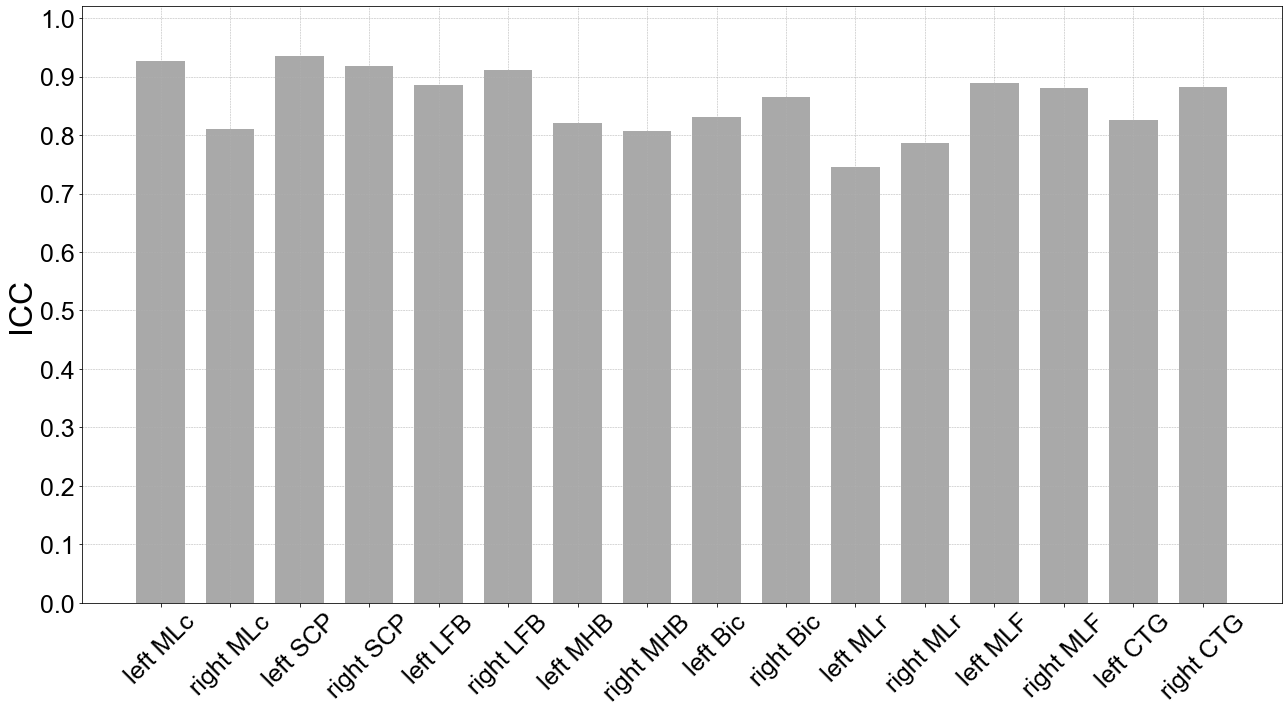

In [9]:
plt.rcParams['font.family'] = 'Arial'
#plt.rcParams['font.weight'] = 'bold'

positions = [i*1.15 for i in range(len(sorted_avg_volume_values))]


plt.figure(figsize=(18, 10))
plt.bar(positions, icc_values, align='center', alpha=1, color='darkgrey')
plt.xticks(positions, label_names, rotation=45,fontsize=25,fontweight='regular')
plt.yticks(np.arange(0.02, 1.12, 0.1),fontsize=25,fontweight='regular')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.ylabel('ICC',fontsize=32,fontweight='regular')

ax = plt.gca()
ylocs, _ = plt.yticks()
new_ylocs = ylocs - 0.02 
ax.set_yticks(new_ylocs)


plt.tight_layout()
plt.savefig('/Users/markolchanyi/Desktop/test_retest_ICC_bars.png', dpi=300)
plt.show()

<ipython-input-10-72deab6f8690>:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


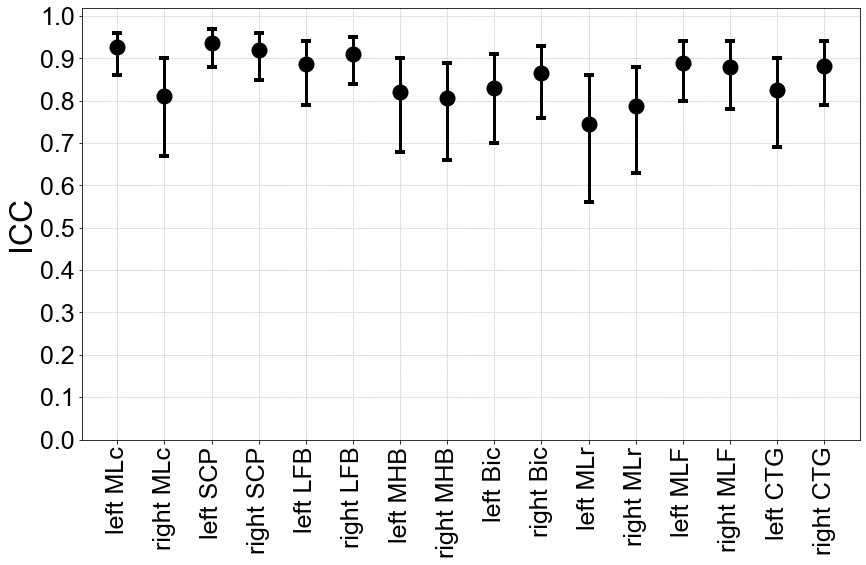

In [10]:
plt.rcParams['font.family'] = 'Arial'

positions = [i*1.15 for i in range(len(icc_values))]

# Calculate the error bars based on 95% CI
yerr = [(icc - ci_low, ci_high - icc) for icc, (ci_low, ci_high) in zip(icc_values, CI95_values)]

# Convert the yerr to a format suitable for errorbar (2 rows: errors below and above the values)
yerr = np.array(yerr).T


fig = plt.figure(figsize=(18, 10))

plot_area = [0.2, 0.2, 0.6, 0.6]  # Modify these values as needed to fit the tick labels
ax = fig.add_axes(plot_area)

plt.errorbar(positions, icc_values, yerr=yerr, fmt='o', color='black', 
             capsize=5,
             capthick=1,
             elinewidth=3,
             ecolor='black',
             markeredgewidth=4,
             markersize=12)
plt.xticks(positions, label_names, rotation=90,fontsize=25,fontweight='regular')
plt.yticks(np.arange(0.02, 1.12, 0.1),fontsize=25,fontweight='regular')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.ylabel('ICC',fontsize=32,fontweight='regular')

ax = plt.gca()
ylocs, _ = plt.yticks()
new_ylocs = ylocs - 0.02
ax.set_yticks(new_ylocs)


plt.tight_layout()
plt.savefig('/Users/markolchanyi/Desktop/BSB_Figs/test_retest_ICC.png', dpi=300)
plt.show()


<ipython-input-11-02325f7d597e>:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


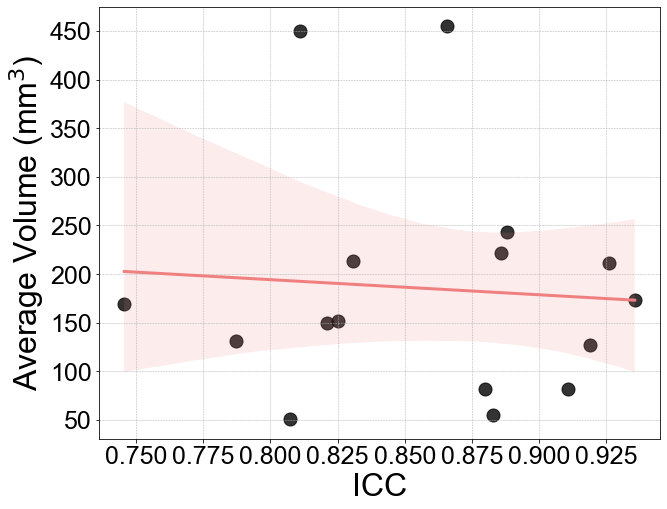

In [11]:
plt.rcParams['font.family'] = 'Arial'
#plt.rcParams['font.weight'] = 'bold'


slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(sorted_icc_values, sorted_avg_volume_values)
r_squared = r_value**2

#dataframe
data = {
    'Average Volume': avg_volume_values,
    'ICC Values': icc_values
}
plot_df = pd.DataFrame(data)

# Plotting with reg. line and 95CI

fig = plt.figure(figsize=(13, 10))

plot_area = [0.2, 0.2, 0.6, 0.6]
ax = fig.add_axes(plot_area)

sns.regplot(x='ICC Values', y='Average Volume', data=plot_df, color='black', scatter_kws={"s": 170}, line_kws={"color": "lightcoral", "linewidth": 3},n_boot=20000)

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlabel('ICC', fontsize=32)
plt.ylabel(r'Average Volume (mm$^3$)', fontsize=32,fontweight='regular')
plt.xticks(fontsize=25,fontweight='regular')
plt.yticks(fontsize=25,fontweight='regular')

plt.tight_layout()
plt.savefig('/Users/markolchanyi/Desktop/BSB_Figs/test_retest_vol_ICC.png', dpi=300)
plt.show()

In [12]:
print(r_squared)

0.005142009106189571


In [13]:
print(p_value)

0.7918545054561686


In [14]:
print(slope)

-155.35434090296383
